# Importing Libraries

In [27]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Model Selection
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

# Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

# Loading Data

In [31]:
df = pd.read_csv('../data/final/data_reduced.csv')

train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

X_train = train_df.drop(columns=['target', 'split'])
y_train = train_df['target']

X_test = test_df.drop(columns=['target', 'split'])
y_test = test_df['target']

# Model Definition

In [32]:
models = {
  'Logistic Regression': LogisticRegression(),
  'SVM': SVC(),
  'Random Forest': RandomForestClassifier()
}

# Model Testing

In [33]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
  cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
  print(f"{name}: Average F1 = {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

Logistic Regression: Average F1 = 0.952 ± 0.019
SVM: Average F1 = 0.955 ± 0.025
Random Forest: Average F1 = 0.925 ± 0.022


# Model Tuning

In [34]:
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["liblinear", "lbfgs"],
        "penalty": ["l2"],  # 'l1' can be added if using 'liblinear'
        "max_iter": [1000]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf", "poly"],
        "gamma": ["scale", "auto"]
    }
}

In [35]:
best_models = {}
results = []

for name, params in param_grids.items():
    print(f"🔍 Tuning {name} ...")
    
    if name == "Logistic Regression":
        model = LogisticRegression(random_state=42)
    else:
        model = SVC(probability=True, random_state=42)
    
    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=cv,
        scoring="f1",
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    
    best_models[name] = grid.best_estimator_
    
    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "Best CV F1": grid.best_score_
    })
    
    print(f"✅ {name} done. Best F1: {grid.best_score_:.3f}")


🔍 Tuning Logistic Regression ...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
✅ Logistic Regression done. Best F1: 0.959
🔍 Tuning SVM ...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
✅ SVM done. Best F1: 0.955


In [36]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="Best CV F1", ascending=False, inplace=True)
results_df

,Model,Best Params,Best CV F1
0,Logistic Regression,"{'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', ...",0.958822
1,SVM,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.955281


In [37]:
best_model = best_models['Logistic Regression']

# Final Evaluation

In [38]:
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       107
           1       0.98      0.92      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.97      0.96      0.96       171



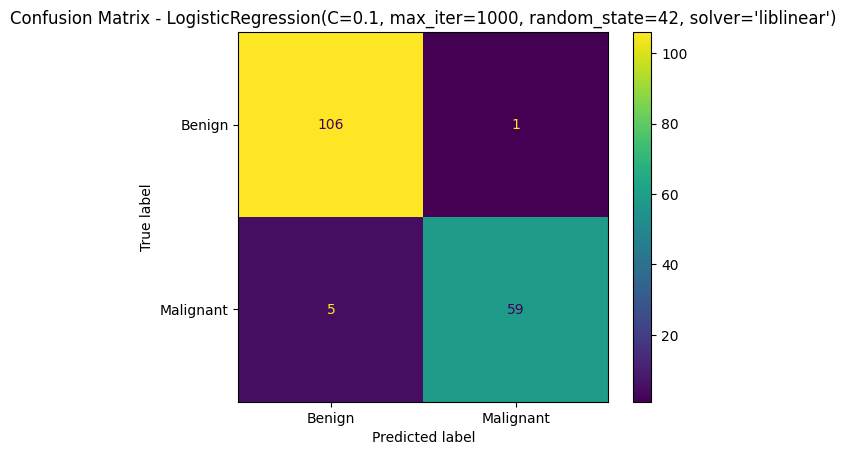

In [43]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=('Benign', 'Malignant')).plot()
plt.title(f'Confusion Matrix - {best_model}')
plt.show()